# Cleaning US Census Data

You just got hired as a Data Analyst at the Census Bureau, which collects census data and creates interesting visualizations and insights from it.

The person who had your job before you left you all the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. Sometimes they would copy and paste certain numbers into Excel to make charts.

The thought of it makes you shiver. This is not scalable or repeatable.

Your boss wants you to make some scatterplots and histograms by the end of the day. Can you get this data into `pandas` and into reasonable shape so that you can make these histograms?

## Inspect the Data!

1. The first visualization your boss wants you to make is a scatterplot that shows average income in a state vs proportion of women in that state.

   Open some of the census `csv` files that came with the kit you downloaded. How are they named? What kind of information do they hold? Will they help us make this graph?

In [1]:
# inspect csv files
print('There are 10 csv files, each one with 6 rows and 11 columns')

There are 10 csv files, each one with 6 rows and 11 columns


2. It will be easier to inspect this data once we have it in a DataFrame. You can't even call `.head()` on these `csv`s! How are you supposed to read them?

   Using `glob`, loop through the census files available and load them into DataFrames. Then, concatenate all of those DataFrames together into one DataFrame, called something like `us_census`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns


csv_list = glob.glob('states*.csv')

df_list = []

for file in csv_list:
    data = pd.read_csv(file, index_col=0)
    # print(data.iloc[:,1:])    # to append all columns except the first
    df_list.append(data)

print('df_list length:', len(df_list))
print('Shape of each df in df_list:', df_list[0].shape)

# merge all dataframes into one
us_census = pd.concat(df_list)

# check df index range
print(us_census.index)    # merged df index goes from 0 to 5, need fix!
# sort df by state
us_census.sort_values('State', ascending=True, inplace=True)
# reset index
us_census.reset_index(drop=True, inplace=True)
# check index again
print('New index range:', us_census.index)

# display us_census
us_census.head()


df_list length: 10
Shape of each df in df_list: (6, 10)
Index([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5,
       0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5],
      dtype='int64')
New index range: RangeIndex(start=0, stop=60, step=1)


,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,Alabama,4830620,3.75%,61.88%,31.25%,0.45%,1.05%,0.03%,"$43,296.36",2341093M_2489527F
1,Alaska,733375,5.91%,60.91%,2.85%,16.39%,5.45%,1.06%,"$70,354.74",384160M_349215F
2,Arizona,6641928,29.57%,57.12%,3.85%,4.36%,2.88%,0.17%,"$54,207.82",3299088M_3342840F
3,Arkansas,2958208,6.22%,71.14%,18.97%,0.52%,1.14%,0.15%,"$41,935.63",1451913M_1506295F
4,California,38421464,37.29%,40.22%,5.68%,0.41%,13.05%,0.35%,"$67,264.78",19087135M_19334329F


3. Look at the `.columns` and the `.dtypes` of the `us_census` DataFrame. Are those datatypes going to hinder you as you try to make histograms?

In [3]:
print(us_census.columns)
print(us_census.dtypes)

Index(['State', 'TotalPop', 'Hispanic', 'White', 'Black', 'Native', 'Asian',
       'Pacific', 'Income', 'GenderPop'],
      dtype='object')
State        object
TotalPop      int64
Hispanic     object
White        object
Black        object
Native       object
Asian        object
Pacific      object
Income       object
GenderPop    object
dtype: object


4. Look at the `head()` of the DataFrame so that you can understand why some of these `dtypes` are objects instead of integers or floats.

   Start to make a plan for how to convert these columns into the right types for manipulation.

## Regex to the Rescue

5. Use regex to turn the `Income` column into a format that is ready for conversion into a numerical type.

In [4]:
# clean all non numeric str in Income column
us_census.Income = us_census.Income.str.replace('[$,]', '', regex=True)
print('us_census.Income dtype:', us_census.Income.dtype)
# convert Income column dtype to numerical
us_census.Income = pd.to_numeric(us_census.Income)
print('New us_census.Income dtype:', us_census.Income.dtype)
us_census.Income[:3]

us_census.Income dtype: object
New us_census.Income dtype: float64


0    43296.36
1    70354.74
2    54207.82
Name: Income, dtype: float64

6. Look at the `GenderPop` column. We are going to want to separate this into two columns, the `Men` column, and the `Women` column.

   Split the column into those two new columns using `str.split` and separating out those results.

In [5]:
# split gender pop by male and female
gender_split = us_census.GenderPop.str.split('_')

gender_split.str.get(0)    # male population
gender_split.str.get(1)    # female population

# create new columns for male and female population respectively, and containing only digits
us_census['Male_pop'] = gender_split.str.get(0).replace('\D', '', regex=True)
us_census['Female_pop'] = gender_split.str.get(1).replace('\D', '', regex=True)

# drop old GenderPop column
us_census = us_census.drop(columns=['GenderPop'], axis=1)

us_census.head(2)


,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,Male_pop,Female_pop
0,Alabama,4830620,3.75%,61.88%,31.25%,0.45%,1.05%,0.03%,43296.36,2341093,2489527
1,Alaska,733375,5.91%,60.91%,2.85%,16.39%,5.45%,1.06%,70354.74,384160,349215


In [6]:
# re-arrange df columns order
us_census = us_census.iloc[:,[0,1,9,10,8,2,3,4,5,6,7]]
us_census.head(2)

,State,TotalPop,Male_pop,Female_pop,Income,Hispanic,White,Black,Native,Asian,Pacific
0,Alabama,4830620,2341093,2489527,43296.36,3.75%,61.88%,31.25%,0.45%,1.05%,0.03%
1,Alaska,733375,384160,349215,70354.74,5.91%,60.91%,2.85%,16.39%,5.45%,1.06%


7. Convert both of the columns into numerical datatypes.

   There is still an `M` or an `F` character in each entry! We should remove those before we convert.

In [7]:
# convert columns to numeric dtypes
us_census['Male_pop'] = pd.to_numeric(us_census['Male_pop'])
us_census['Female_pop'] = pd.to_numeric(us_census['Female_pop'])
us_census.dtypes

State          object
TotalPop        int64
Male_pop        int64
Female_pop    float64
Income        float64
Hispanic       object
White          object
Black          object
Native         object
Asian          object
Pacific        object
dtype: object

8. Now you should have the columns you need to make the graph and make sure your boss does not slam a ruler angrily on your desk because you've wasted your whole day cleaning your data with no results to show!

   Use matplotlib to make a scatterplot!
   
   ```py
   plt.scatter(the_women_column, the_income_column)
   ```
   
   Remember to call `plt.show()` to see the graph!

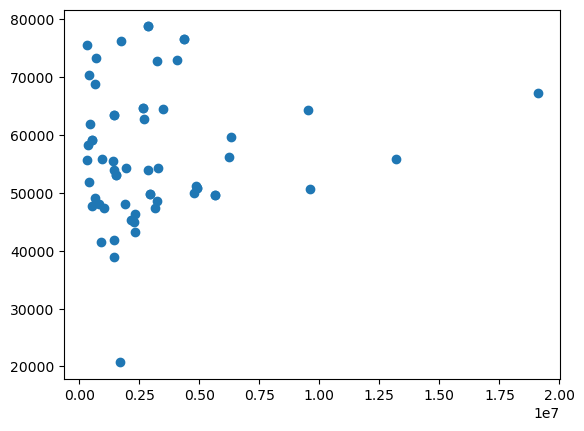

<Figure size 640x480 with 0 Axes>

In [8]:
plt.scatter(x='Male_pop', y='Income', data=us_census)
plt.show(); plt.clf()

9. You want to double check your work. You know from experience that these monstrous csv files probably have `nan` values in them! Print out your column with the number of women per state to see.

   We can fill in those `nan`s by using pandas' `.fillna()` function.
   
   You have the `TotalPop` per state, and you have the `Men` per state. As an estimate for the `nan` values in the `Women` column, you could use the `TotalPop` of that state minus the `Men` for that state.
   
   Print out the `Women` column after filling the `nan` values to see if it worked!

In [9]:
# Handling missing values
# us_census.info()
print(us_census.isna().any())

# Missing data in Female_pop series
# subset row for missing values in Female_pop column
print(us_census[['State', 'Female_pop']][us_census.Female_pop.isna()])
# print(us_census[us_census.Female_pop.isna()].index)
# counting missing values Female_pop
print('Missing data in Female_pop:', us_census.Female_pop.isna().value_counts())
# fill missing data in Female_pop column
us_census.Female_pop = us_census.Female_pop.fillna(us_census.TotalPop - us_census.Male_pop)
# counting missing values after fillna
print('Missing data in Female_pop:', us_census.Female_pop.isna().value_counts())


State         False
TotalPop      False
Male_pop      False
Female_pop     True
Income        False
Hispanic      False
White         False
Black         False
Native        False
Asian         False
Pacific        True
dtype: bool
       State  Female_pop
23  Maryland         NaN
24  Maryland         NaN
31   Montana         NaN
Missing data in Female_pop: Female_pop
False    57
True      3
Name: count, dtype: int64
Missing data in Female_pop: Female_pop
False    60
Name: count, dtype: int64


In [10]:
# Missing data in Pacific series
# fill missing data in 'Pacific' column
print('Missing values Pacific column:', us_census.Pacific.isna().sum())
us_census.Pacific = us_census.Pacific.fillna(0)
print('Missing values Pacific column:', us_census.Pacific.isna().sum())


Missing values Pacific column: 5
Missing values Pacific column: 0


10. We forgot to check for duplicates! Use `.duplicated()` on your `census` DataFrame to see if we have duplicate rows in there.

In [11]:
# check duplicated observation (row)
print('Duplicated rows:', us_census.duplicated().sum())
us_census[us_census.duplicated()]


Duplicated rows: 9


,State,TotalPop,Male_pop,Female_pop,Income,Hispanic,White,Black,Native,Asian,Pacific
6,Colorado,5278906,2648667,2630239.0,64657.80,20.78%,69.90%,3.55%,0.57%,2.66%,0
12,Georgia,10006693,4883331,5123362.0,50811.08,8.42%,54.29%,32.09%,0.19%,3.10%,0.05%
18,Iowa,3093526,1534595,1558931.0,53017.75,5.30%,87.72%,3.26%,0.29%,1.70%,0.06%
24,Maryland,5930538,2872643,3057895.0,78765.40,8.47%,52.68%,30.68%,0.20%,5.33%,0.04%
30,Missouri,6045448,2964003,3081445.0,49763.99,4.04%,77.51%,14.12%,0.36%,1.62%,0.10%
36,New Jersey,8904413,4343027,4561386.0,76581.08,18.75%,56.49%,14.39%,0.12%,8.16%,0.03%
42,Ohio,11575977,5662893,5913084.0,49655.25,3.67%,75.90%,16.21%,0.17%,1.62%,0.02%
48,Rhode Island,1053661,510388,543273.0,59125.27,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%
54,Utah,2903379,1459229,1444150.0,63488.92,13.47%,79.41%,1.02%,1.08%,2.20%,0.83%


11. Drop those duplicates using the `.drop_duplicates()` function.

In [12]:
# drop duplicated data
us_census = us_census.drop_duplicates()
print('Verify duplicated rows:', us_census.duplicated().sum())

Verify duplicated rows: 0


In [13]:
# reset df index again to avoid data inconsistencies
us_census.reset_index(drop=True, inplace=True) 
print(us_census.index)
us_census.head(10)
# us_census.head(20)

RangeIndex(start=0, stop=51, step=1)


,State,TotalPop,Male_pop,Female_pop,Income,Hispanic,White,Black,Native,Asian,Pacific
0,Alabama,4830620,2341093,2489527.0,43296.36,3.75%,61.88%,31.25%,0.45%,1.05%,0.03%
1,Alaska,733375,384160,349215.0,70354.74,5.91%,60.91%,2.85%,16.39%,5.45%,1.06%
2,Arizona,6641928,3299088,3342840.0,54207.82,29.57%,57.12%,3.85%,4.36%,2.88%,0.17%
3,Arkansas,2958208,1451913,1506295.0,41935.63,6.22%,71.14%,18.97%,0.52%,1.14%,0.15%
4,California,38421464,19087135,19334329.0,67264.78,37.29%,40.22%,5.68%,0.41%,13.05%,0.35%
5,Colorado,5278906,2648667,2630239.0,64657.80,20.78%,69.90%,3.55%,0.57%,2.66%,0
6,Connecticut,3593222,1751607,1841615.0,76146.56,15.60%,67.68%,10.35%,0.13%,4.02%,0.02%
7,Delaware,926454,448413,478041.0,61827.98,8.82%,64.63%,20.74%,0.26%,3.27%,0
8,District of Columbia,647484,306674,340810.0,75466.36,9.17%,33.10%,51.78%,0.20%,3.38%,0.03%
9,Florida,19645772,9600009,10045763.0,50690.19,21.34%,59.08%,15.17%,0.21%,2.28%,0.05%


12. Make the scatterplot again. Now, it should be perfect! Your job is secure, for now.

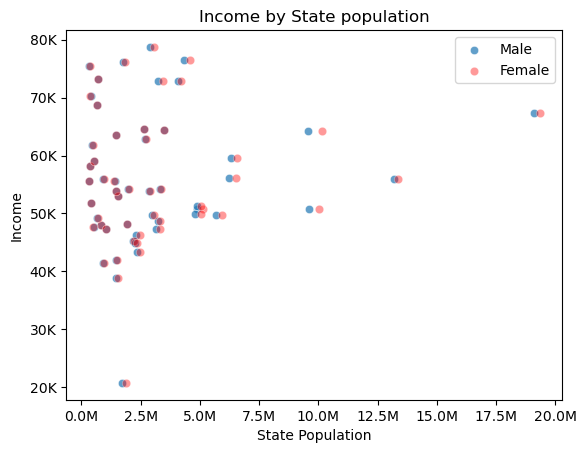

<Figure size 640x480 with 0 Axes>

In [14]:
sns.scatterplot(data=us_census, x='Male_pop', y='Income', alpha=0.7, label='Male')
sns.scatterplot(data=us_census, x='Female_pop', y='Income', alpha=0.4, label='Female', c='r')
plt.xlabel('state population'.title())
plt.yticks(ticks=np.arange(2e4,9e4,1e4), labels=[f'{i}K' for i in range(20,90,10)])
plt.xticks(ticks=np.arange(0,2.1e7,25e5), labels=[f'{i}M' for i in np.arange(0,21,2.5)])
plt.title('Income by State population')
plt.show()
plt.clf()

In [15]:
# Sorting State by Income descending order
result = us_census.sort_values('Income', ascending=False).reset_index()
# result[['State','TotalPop','Income']]

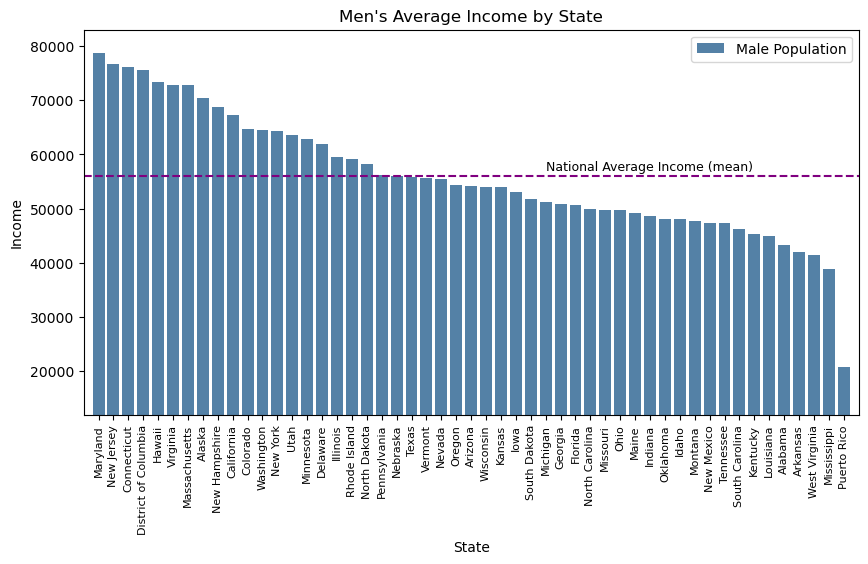

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(x='State', y='Income', data=us_census, order=result['State'], label='Male Population', color='steelblue')
plt.axhline(us_census.Income.mean(), linestyle='dashed', c='purple')
plt.legend()
plt.xticks(rotation=90, fontsize=8)
plt.title('Men\'s Average Income by State')
plt.annotate('National Average Income (mean)', xy=(30, 5.7e4), fontsize=9)
plt.axis([-1,51, 12000, 83e3])
plt.show()
plt.clf()

## Histogram of Races

13. Now your boss wants you to make a bunch of histograms out of the race data that you have. Look at the `.columns` again to see what the race categories are.

In [17]:
print(us_census.iloc[:, 5:11].head(3))
us_census.dtypes

  Hispanic   White   Black  Native  Asian Pacific
0    3.75%  61.88%  31.25%   0.45%  1.05%   0.03%
1    5.91%  60.91%   2.85%  16.39%  5.45%   1.06%
2   29.57%  57.12%   3.85%   4.36%  2.88%   0.17%


State          object
TotalPop        int64
Male_pop        int64
Female_pop    float64
Income        float64
Hispanic       object
White          object
Black          object
Native         object
Asian          object
Pacific        object
dtype: object

14. Try to make a histogram for each one!

    You will have to get the columns into the numerical format, and those percentage signs will have to go.
    
    Don't forget to fill the `nan` values with something that makes sense! You probably dropped the duplicate rows when making your last graph, but it couldn't hurt to check for duplicates again.

In [18]:
group_list = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']

for group in group_list:
    us_census[group] = us_census[group].replace('[\%\s]', '', regex=True)
    us_census[group] = pd.to_numeric(us_census[group])

print(us_census[group_list].head(3))
us_census.dtypes

   Hispanic  White  Black  Native  Asian  Pacific
0      3.75  61.88  31.25    0.45   1.05     0.03
1      5.91  60.91   2.85   16.39   5.45     1.06
2     29.57  57.12   3.85    4.36   2.88     0.17


State          object
TotalPop        int64
Male_pop        int64
Female_pop    float64
Income        float64
Hispanic      float64
White         float64
Black         float64
Native        float64
Asian         float64
Pacific       float64
dtype: object

In [19]:
# get column index
[us_census.columns.get_loc(col) for col in us_census.columns]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

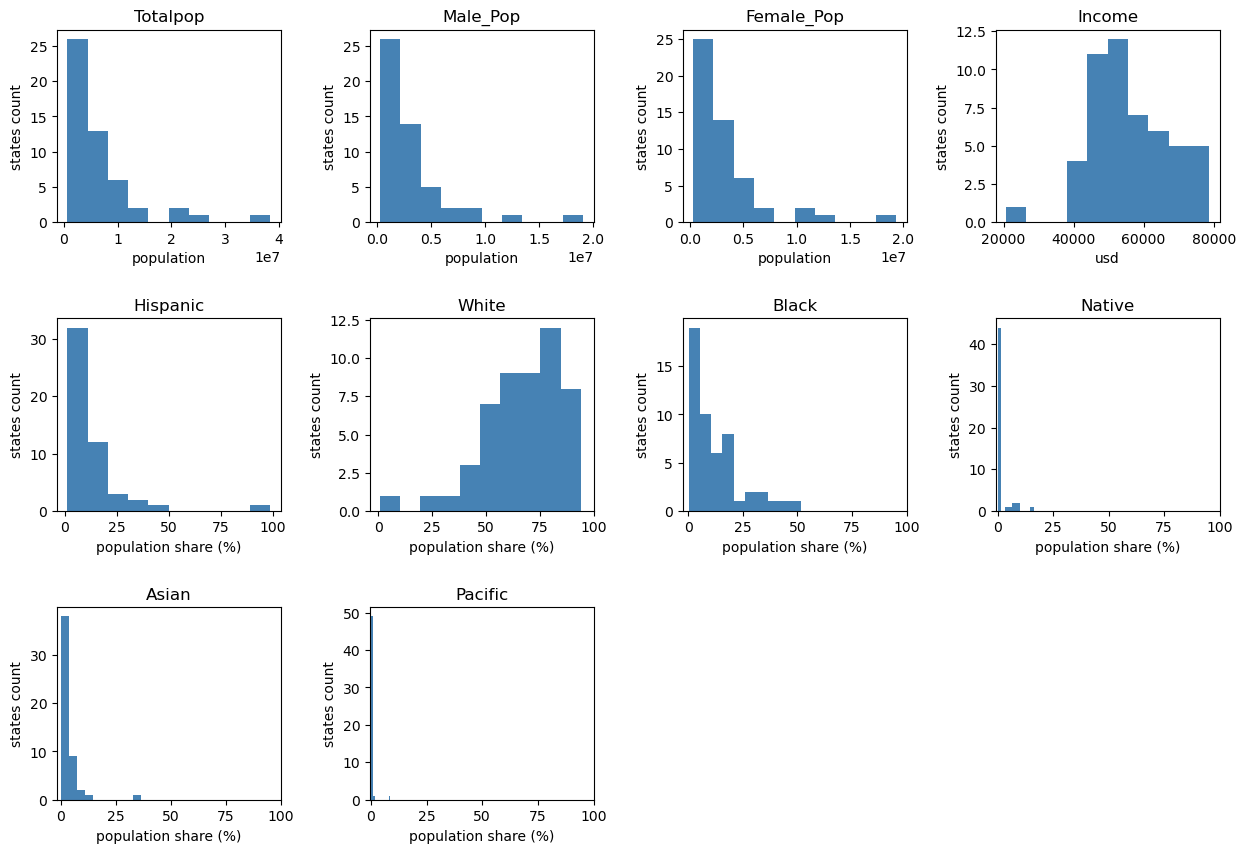

<Figure size 640x480 with 0 Axes>

In [20]:
# display histogram
plt.figure(figsize=(15, 10))

for col in us_census.columns:
  if us_census[col].dtype != 'object':
  # print(col)
    col_index = us_census.columns.get_loc(col)    # get the column
    plt.subplot(3, 4, col_index)
    plt.hist(us_census[col], bins=10, color='steelblue')
    plt.title(str(col).title())
    plt.ylabel('states count')
    if col_index < 4:
      plt.xlabel('population')
    elif col_index == 4:
      plt.xlabel('usd')
    else:
      plt.xlabel('population share (%)')
      plt.xticks(np.linspace(0,100, 5))

    
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show(); plt.clf()

## Get Creative

15. Phew. You've definitely impressed your boss on your first day of work.

    But is there a way you really convey the power of pandas and Python over the drudgery of `csv` and Excel?
    
    Try to make some more interesting graphs to show your boss, and the world! You may need to clean the data even more to do it, or the cleaning you have already done may give you the ease of manipulation you've been searching for.

In [21]:
# state sorted by TotalPop
totalpop_sort = us_census.sort_values('TotalPop', ascending=False).reset_index(drop=True)

In [22]:
us_census_melt = pd.melt(
    frame=us_census, 
    id_vars=['State', 'TotalPop', 'Male_pop', 'Female_pop', 'Income'], 
    value_vars=['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific'], 
    var_name='Community', 
    value_name='Comm_share'
    )

us_census_melt.rename(columns={'TotalPop':'population', 'Male_pop':'Male', 'Female_pop':'Female'}, inplace=True)
us_census_melt.drop(columns=['Male', 'Female'], inplace=True)
us_census_melt.rename(str.lower, axis=1, inplace=True)
us_census_melt.head()

,state,population,income,community,comm_share
0,Alabama,4830620,43296.36,Hispanic,3.75
1,Alaska,733375,70354.74,Hispanic,5.91
2,Arizona,6641928,54207.82,Hispanic,29.57
3,Arkansas,2958208,41935.63,Hispanic,6.22
4,California,38421464,67264.78,Hispanic,37.29


In [23]:
us_census_melt.groupby(['community']).comm_share.sum().sort_values(ascending=False).index

Index(['White', 'Hispanic', 'Black', 'Asian', 'Native', 'Pacific'], dtype='object', name='community')

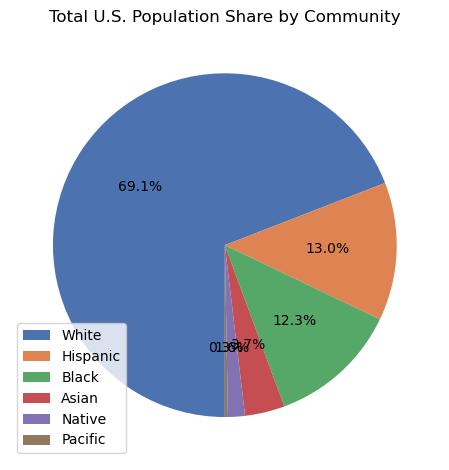

In [24]:
data_ = us_census_melt.groupby(['community']).comm_share.sum().sort_values(ascending=False)
labels_ = us_census_melt.groupby(['community']).comm_share.sum().sort_values(ascending=False).index

sns.set_palette('deep')


plt.pie(data_, autopct='%1.1f%%', rotatelabels=True, startangle=270, counterclock=False)
plt.title('Total U.S. Population Share by Community')
plt.legend(labels_, loc='lower left')
plt.tight_layout()
plt.show()


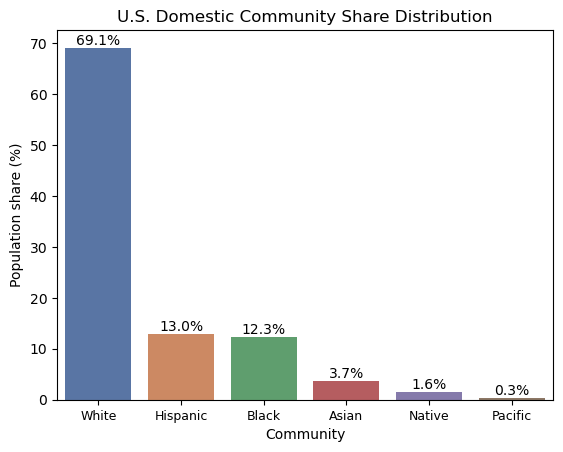

In [25]:
ax = sns.barplot(x=labels_,y=[(100*x/data_.sum()) for x in data_])
# plt.yticks(np.arange(0, 110, 10))
plt.ylabel('Population share (%)')
plt.xlabel('Community',fontsize=10)
plt.xticks(fontsize=9)
plt.title('U.S. Domestic Community Share Distribution')

# plot percentage with container method
for p in ax.containers:
    ax.bar_label(p, fmt='%.1f%%', label_type='edge',fontsize=10)

# # plot percentage with annotation method
# for p in ax.patches:
#     width = p.get_width()
#     height = p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate(f'{round(height,1)}%', (x + width/2, y + height*1.02), ha='center', fontsize=9)

plt.show()

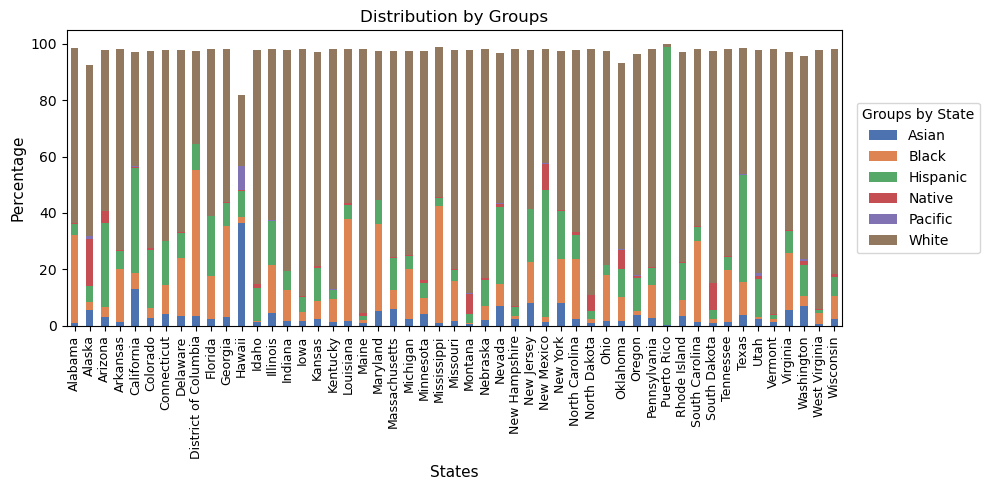

In [26]:
# Pivot your data to get states as index, ethnic groups as columns, and percentages as values
pivoted_data = us_census_melt.pivot_table(index='state', columns='community', values='comm_share', aggfunc='sum')

# Plotting the stacked bar plot
pivoted_data.plot(kind='bar', stacked=True, figsize=(10, 5))

# Customize the plot
plt.title('Distribution by Groups', fontsize=12)
plt.xlabel('States', fontsize=11)
plt.ylabel('Percentage', fontsize=11)
plt.xticks(rotation=90, fontsize=9)
plt.legend(title='Groups by State', loc=6, bbox_to_anchor=(1.01,0.5))
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()


/var/folders/f4/wfdsvyhd4471p6frw6wp_pb80000gn/T/ipykernel_4446/2430575482.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(i*10)}M' for i in np.arange(0,4.5, 0.5)], fontsize=9)


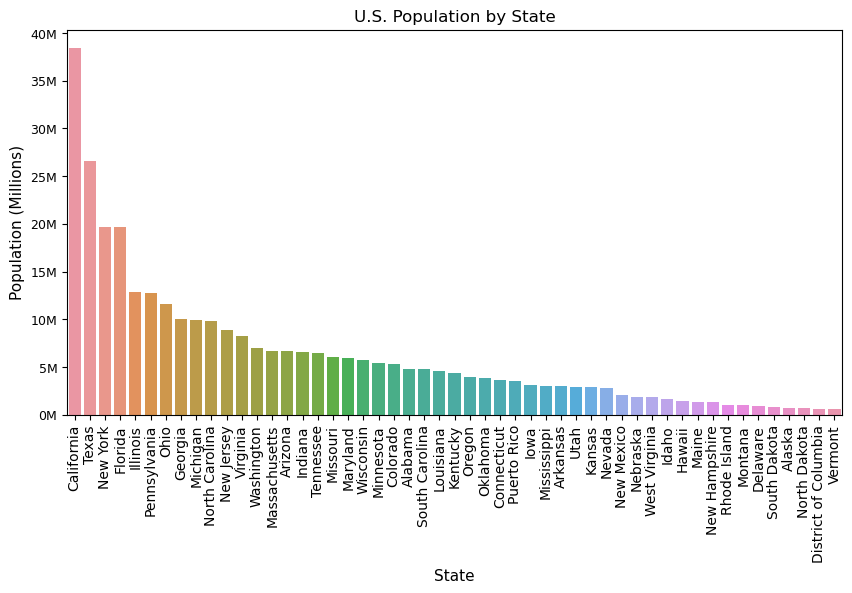

In [27]:
# plot us population
plt.figure(figsize=(10,5))
state_pop_sorted = us_census.sort_values('TotalPop', ascending=False).State
ax = sns.barplot(us_census, x='State', y='TotalPop', order=state_pop_sorted)
plt.xticks(rotation='vertical')
ax.set_yticklabels([f'{int(i*10)}M' for i in np.arange(0,4.5, 0.5)], fontsize=9)
plt.ylabel('Population (Millions)', fontsize=11)
plt.xlabel('State', fontsize=11)
plt.title('U.S. Population by State', fontsize=12)
plt.show()

In [28]:
# melt male and female genres population
pop_melt = pd.melt(
    frame=us_census.rename(columns={'Male_pop':'Male', 'Female_pop':'Female'}), 
    id_vars=['State', 'TotalPop', 'Income'], 
    value_vars=['Male', 'Female'],
    var_name='Gender', 
    value_name='Pop_gender'
)

pop_melt.rename(str.lower, inplace=True, axis=1)
pop_melt.dtypes


state          object
totalpop        int64
income        float64
gender         object
pop_gender    float64
dtype: object

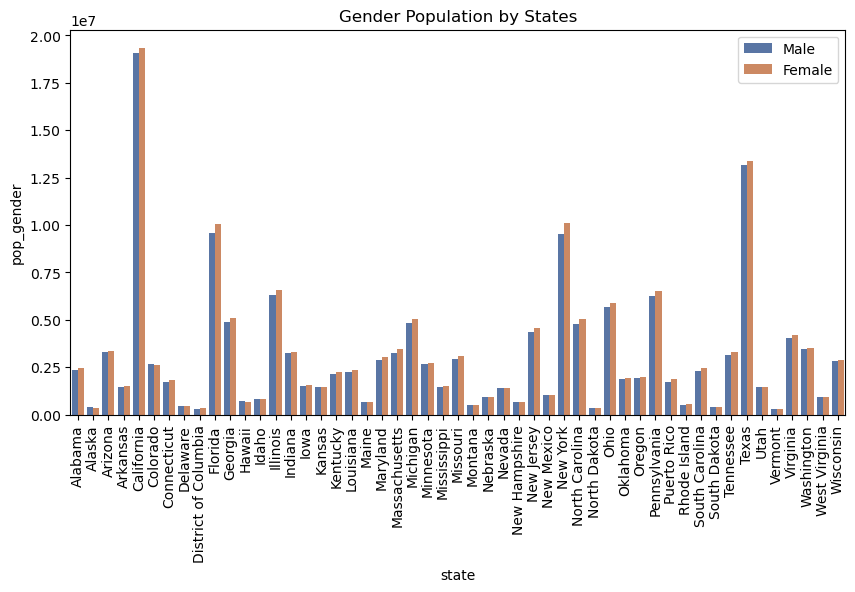

In [29]:
# Gender Population by States
plt.figure(figsize=(10,5))
sns.barplot(data= pop_melt, x='state', y='pop_gender', hue='gender')
plt.xticks(rotation='vertical')
plt.title('Gender Population by States')
plt.legend()
plt.show()

# pop_melt.groupby(['state', 'gender']).pop_gender.value_counts()

